# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

You can use ** Keras ** to implement your model. Read more at [keras.io](https://keras.io/).

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0)). You are not expected to model your architecture precisely using this model nor get the same performance levels, but this is more to show an exampe of an approach used to solve this particular problem. We encourage you to try out different architectures for yourself and see what works best for you. Here is a useful [forum post](https://discussions.udacity.com/t/goodfellow-et-al-2013-architecture/202363) discussing the architecture as described in the paper and here is [another one](https://discussions.udacity.com/t/what-loss-function-to-use-for-multi-digit-svhn-training/176897) discussing the loss function.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import random
import pickle
import h5py
from os import path
from scipy.io import loadmat

from keras.utils.np_utils import to_categorical
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Flatten, Dropout, Convolution2D, MaxPooling2D
from keras.models import load_model, Model
from keras.optimizers import SGD
from keras.utils.visualize_util import plot
from keras import backend
backend.set_image_dim_ordering('tf')

%matplotlib inline

# utility functions

HEIGHT = 28
WIDTH = 140

def save_pickle(file_Name, data):
    fileObject = open(file_Name,'wb') 
    pickle.dump(data,fileObject)   
    fileObject.close()
    
def load_pickle(file_Name):
    fileObject = open(file_Name,'rb')
    data = pickle.load(fileObject)
    return data

def save_models(digit_model, Path):
    digit_model.save(path.join(Path, 'digit_model_{0}.h5'.format(i)))
    print('model saved')
        
def visualize(model):
    plot(model, to_file='model.png', show_shapes=True, show_layer_names=False)
    graph = plt.imread('model.png')
    plt.figure(figsize=(20,20))
    plt.axis('off')
    plt.imshow(graph)
    
def plot_samples(X_train):
    plt.figure(figsize=(10, 8))
    for i in range(8):
        plt.subplot(4,2,i+1)   
        j = np.random.randint(0, len(X_train))
        chosen = X_train[j]
        plt.imshow(chosen)
        plt.axis('off')

ModuleNotFoundError: No module named 'cv2'

In [25]:
def create_MNIST_concat_dataset(train_size=10000, test_size=2000):
    (X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = mnist.load_data()
    num_digits=5
    def create(features, labels, size):
        indices = np.arange(len(features))
        result_features = []
        result_labels = []
        for i in range(size):
            chosen_indices = np.random.choice(indices, num_digits)
            digits = random.randint(2, num_digits)
            #print(digits)
            chosen_features = features[chosen_indices[:digits]]
            chosen_labels = to_categorical(labels)[chosen_indices[:digits]]
            temp1 = np.zeros((digits,1), dtype=np.float64)
            chosen_labels = np.append(chosen_labels,temp1,axis=1) # add column for none
            temp2 = np.zeros((1,11), dtype=np.float64)
            temp2[0][10] = 1
            
            img = np.concatenate(list(chosen_features), axis=1)
            padding = np.zeros((28, 28))
            
            for j in range(5-digits):
                chosen_labels = np.append(chosen_labels,temp2,axis=0) # add rows for none
                img = np.concatenate((img, padding), axis=1)
            #print chosen_labels
            
            img = cv2.resize(img,(WIDTH, HEIGHT))
            img = img / 255
            
            result_features.append(img)
            result_labels.append(chosen_labels)
            
            #print(result_features)
        return (np.array(result_features), np.array(result_labels))
    
    new_X_train, new_y_train = create(X_train_raw, y_train_raw, train_size)
    new_X_test, new_y_test = create(X_test_raw, y_test_raw, test_size)
    new_y_train = list(np.swapaxes(new_y_train,1,0))
    new_y_test = list(np.swapaxes(new_y_test,1,0))
    return (new_X_train, new_y_train, new_X_test, new_y_test)

In [ ]:
X_train, y_train, X_test, y_test = create_MNIST_concat_dataset(train_size=10000, test_size=2000)

dataObj = {'X_train': X_train,
           'y_train': y_train,
           'X_test': X_test,
           'y_test': y_test}

save_pickle("MNIST_concat.pickle", dataObj)
del X_train, y_train, X_test, y_test, dataObj


In [3]:
# load data from pickle

dataset = load_pickle("MNIST_concat.pickle")
X_train = dataset['X_train']
y_train = dataset['y_train']
X_test = dataset['X_test']
y_test = dataset['y_test']
X_train = np.reshape(X_train, (len(X_train), HEIGHT, WIDTH, 1))
X_test = np.reshape(X_test, (len(X_test), HEIGHT, WIDTH, 1))
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', y_train[0].shape)
print('y_test', y_test[0].shape)
del dataset

X_train (10000, 28, 140, 1)
X_test (2000, 28, 140, 1)
y_train (10000, 11)
y_test (2000, 11)


In [34]:
def create_model(h, w, c):

    x = Input((h, w, c))

    m = Convolution2D(16, 3, 3, subsample=(1, 2), input_shape=(HEIGHT, WIDTH, 1), activation='relu')(x)
    m = Convolution2D(32, 3, 3, subsample=(2, 2), activation='relu')(m)
    m = MaxPooling2D(pool_size=(2, 2))(m)
    m = Dropout(0.25)(m)

    m = Flatten()(m)
    m = Dense(128, activation='relu')(m)
    m = Dropout(0.5)(m)
    
    digit0 = Dense(11, activation='softmax')(m)
    digit1 = Dense(11, activation='softmax')(m)
    digit2 = Dense(11, activation='softmax')(m)
    digit3 = Dense(11, activation='softmax')(m)
    digit4 = Dense(11, activation='softmax')(m)
    
    model = Model(input=x, output=[digit0, digit1, digit2, digit3, digit4])

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    return model

In [ ]:
MNIST_model = create_model(HEIGHT, WIDTH, 1)
#MNIST_model = load_model(path.join('DigitModels', 'MNIST_model.h5'))
%time MNIST_model.fit(X_train, list(y_train), nb_epoch=10, validation_split=0.2, verbose=2)
MNIST_model.save(path.join('DigitModels', 'MNIST_model.h5'))

Train on 8000 samples, validate on 2000 samples
Epoch 1/10


In [4]:
MNIST_model = load_model(path.join('DigitModels', 'MNIST_model'))
metrics = MNIST_model.evaluate(X_test, y_test, batch_size=32, verbose=0)
for i in range(5):
    print("accuracy for digit {0} is {1}".format(i+1, metrics[i+6]))

accuracy for digit 1 is 0.961
accuracy for digit 2 is 0.963
accuracy for digit 3 is 0.962
accuracy for digit 4 is 0.975
accuracy for digit 5 is 0.971


I think it says: 
3029 

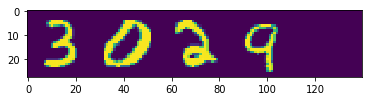

I think it says: 
41   

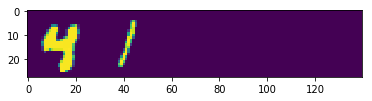

I think it says: 
90   

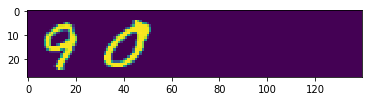

I think it says: 
8870 

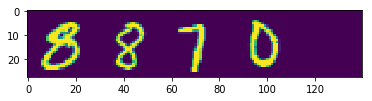

In [38]:
for j in range(4):
    r = random.randint(0, len(X_test))
    pred = MNIST_model.predict(np.array([X_test[r]]))
    print('I think it says: ')
    for i in pred:
        n = np.argmax(i)
        if n == 10:
            n = ' '
        print(n, end='')
    plt.imshow(X_test[r].reshape(HEIGHT,WIDTH))
    plt.show()

### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** I used a convolutional neural network with 5 outputs. The convolutional layers have the same weights for all the digits, but each digits has its own fully connected layer. Intuitively, all the digit classifiers are very similar so the weights of the convolutional layers should be shared between digits. After coming up with the model, I tuned the hyper-parameters to optimize it, including the solver, the number of convolution filters, and the strides. The final trained model has >95% accuracy on all 5 digits.

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:**
I used a convolution neural network with dropouts. The model architecture is displayed below. The probabilities for the two dropouts are 0.25 and 0.5 respectively.

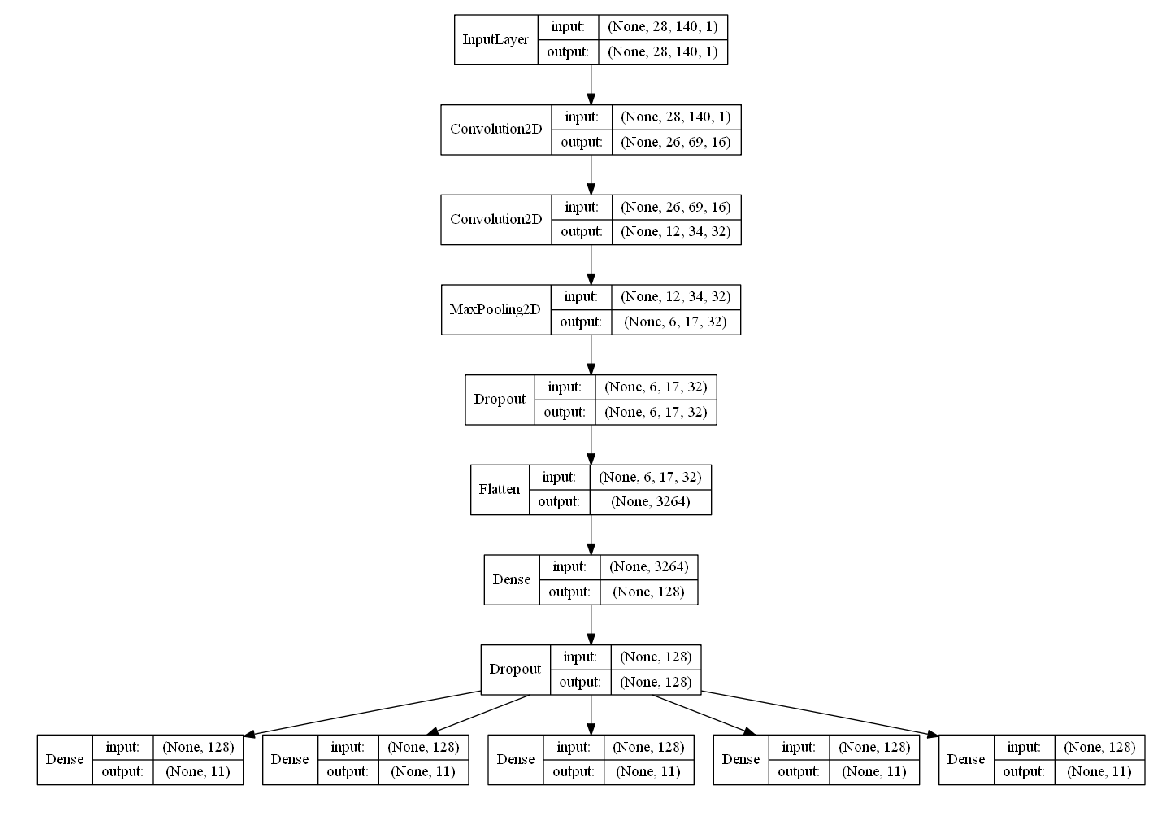

In [8]:
visualize(MNIST_model)

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:** I trained the model with 8000 training images, 2000 validation images, and tested with 2000 images. The model is trained on 10 epochs. The synthetic data is generated by randomly selecting 2 to 5 digits from mnist and using opencv to concatenate them horizontally into a sequence of numbers.

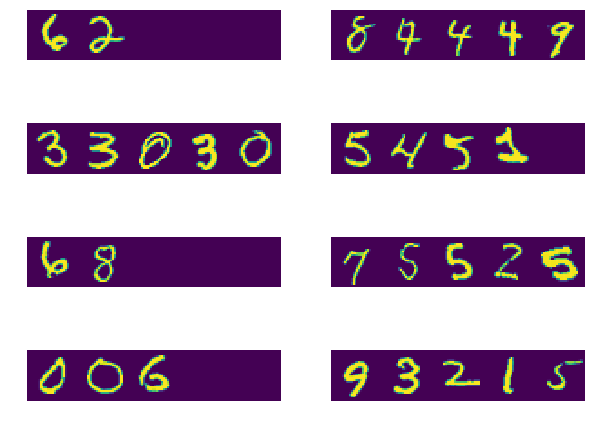

In [80]:
X_print = np.reshape(X_train, (len(X_train), HEIGHT, WIDTH))
plot_samples(X_print)

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [100]:
cropped_path = 'F:\Datasets\SVHNd'

In [101]:
def prepare_SVHN_cropped(grey):
    train_data = loadmat(path.join(cropped_path, 'train_32x32.mat'))
    test_data = loadmat(path.join(cropped_path, 'test_32x32.mat'))
    train_X = train_data['X']
    train_y = train_data['y']
    test_X = test_data['X']
    test_y = test_data['y']
    train_X = np.rollaxis(train_X,3,0)
    test_X = np.rollaxis(test_X,3,0)
    if grey:
        train_X_grey = []
        test_X_grey = []
        for i in range(len(train_X)):
            train_X_grey.append(cv2.cvtColor(train_X[i], cv2.COLOR_BGR2GRAY))
        for i in range(len(test_X)):
            test_X_grey.append(cv2.cvtColor(test_X[i], cv2.COLOR_BGR2GRAY))
        train_X = np.array(train_X_grey)
        test_X = np.array(test_X_grey)
    train_X = train_X / 255
    test_X = test_X / 255
    train_y = to_categorical(train_y)
    test_y = to_categorical(test_y)
    obj = {
        'X_train': train_X,
        'y_train': train_y,
        'X_test': test_X,
        'y_test': test_y
    }
    save_pickle('SVHN_cropped.pickle', obj)
    
prepare_SVHN_cropped(False)

In [7]:
dataset = load_pickle('SVHN_cropped.pickle')
X_train2 = dataset['X_train']
y_train2 = dataset['y_train']
X_test2 = dataset['X_test']
y_test2 = dataset['y_test']
del dataset
print(X_train2.shape)
print(X_test2.shape)
print(y_train2.shape)
print(y_test2.shape)

(73257, 32, 32, 3)
(26032, 32, 32, 3)
(73257, 11)
(26032, 11)


[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


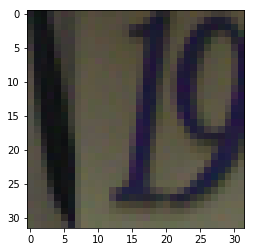

In [10]:
print(y_train2[0])
plt.imshow(X_train2[0])
plt.show()

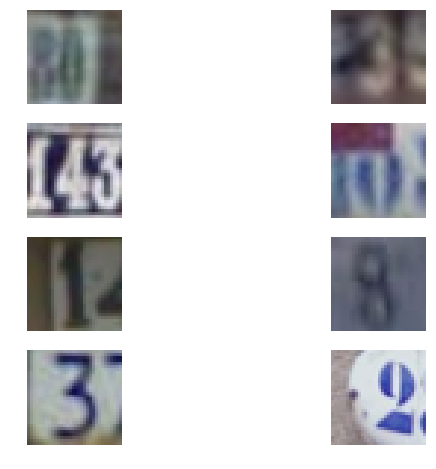

In [104]:
plot_samples(X_train2)

In [247]:
def create_original_model(h, w, c):

    x = Input((h, w, c))

    m = Convolution2D(16, 3, 3, subsample=(1, 2), input_shape=(HEIGHT, WIDTH, 1), activation='relu')(x)
    m = Convolution2D(32, 3, 3, subsample=(2, 2), activation='relu')(m)
    m = MaxPooling2D(pool_size=(2, 2))(m)
    m = Dropout(0.25)(m)

    m = Flatten()(m)
    m = Dense(128, activation='relu')(m)
    m = Dropout(0.5)(m)
    
    digit = Dense(11, activation='softmax')(m)
    
    model = Model(input=x, output=digit)

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    return model

In [248]:
original_model = create_original_model(32, 32, 3)
%time original_model.fit(X_train2, y_train2, batch_size=64, nb_epoch=10, verbose=2, validation_split=0.2)
original_model.save('original_digit_model.h5')

Train on 58605 samples, validate on 14652 samples
Epoch 1/10
22s - loss: 1.6483 - acc: 0.4460 - val_loss: 0.8776 - val_acc: 0.7542
Epoch 2/10
14s - loss: 0.9461 - acc: 0.7080 - val_loss: 0.6554 - val_acc: 0.8090
Epoch 3/10
13s - loss: 0.7952 - acc: 0.7567 - val_loss: 0.5973 - val_acc: 0.8245
Epoch 4/10
15s - loss: 0.7168 - acc: 0.7802 - val_loss: 0.5360 - val_acc: 0.8475
Epoch 5/10
16s - loss: 0.6836 - acc: 0.7914 - val_loss: 0.5218 - val_acc: 0.8444
Epoch 6/10
17s - loss: 0.6553 - acc: 0.7991 - val_loss: 0.4867 - val_acc: 0.8591
Epoch 7/10
15s - loss: 0.6345 - acc: 0.8074 - val_loss: 0.5103 - val_acc: 0.8552
Epoch 8/10
16s - loss: 0.6201 - acc: 0.8123 - val_loss: 0.4884 - val_acc: 0.8620
Epoch 9/10
17s - loss: 0.6045 - acc: 0.8171 - val_loss: 0.4693 - val_acc: 0.8606
Epoch 10/10
15s - loss: 0.6011 - acc: 0.8175 - val_loss: 0.4389 - val_acc: 0.8696
Wall time: 2min 45s


In [249]:
original_digit_model = load_model('cropped_digit_model.h5')
m = original_digit_model.evaluate(X_test2, y_test2, batch_size=64, verbose=0)
print('accuracy {0}'.format(m[1]))

accuracy 0.8438460356484327


In [25]:
def create_cropped_digit_model():
    model = Sequential()
    
    model.add(Convolution2D(32, 3, 3, border_mode='same',
                input_shape=(32, 32, 3), activation='relu'))
    model.add(Convolution2D(32, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(11, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    return model

cropped_digit_model = create_cropped_digit_model()

In [26]:
%time cropped_digit_model.fit(X_train2, y_train2, batch_size=64, nb_epoch=10, verbose=2, validation_split=0.2)
cropped_digit_model.save('cropped_digit_model.h5')

Train on 58605 samples, validate on 14652 samples
Epoch 1/10
55s - loss: 1.5346 - acc: 0.4731 - val_loss: 0.6081 - val_acc: 0.8204
Epoch 2/10
54s - loss: 0.5696 - acc: 0.8279 - val_loss: 0.4365 - val_acc: 0.8702
Epoch 3/10
54s - loss: 0.4594 - acc: 0.8596 - val_loss: 0.3666 - val_acc: 0.8917
Epoch 4/10
53s - loss: 0.3980 - acc: 0.8799 - val_loss: 0.3361 - val_acc: 0.9019
Epoch 5/10
54s - loss: 0.3621 - acc: 0.8911 - val_loss: 0.3022 - val_acc: 0.9130
Epoch 6/10
54s - loss: 0.3317 - acc: 0.9005 - val_loss: 0.2908 - val_acc: 0.9141
Epoch 7/10
54s - loss: 0.3088 - acc: 0.9084 - val_loss: 0.2742 - val_acc: 0.9196
Epoch 8/10
54s - loss: 0.2943 - acc: 0.9123 - val_loss: 0.2746 - val_acc: 0.9231
Epoch 9/10
53s - loss: 0.2770 - acc: 0.9185 - val_loss: 0.2651 - val_acc: 0.9216
Epoch 10/10
53s - loss: 0.2673 - acc: 0.9219 - val_loss: 0.2564 - val_acc: 0.9244
Wall time: 9min 2s


In [250]:
cropped_digit_model = load_model('cropped_digit_model.h5')
m = cropped_digit_model.evaluate(X_test2, y_test2, batch_size=64, verbose=0)
print('accuracy {0}'.format(m[1]))

accuracy 0.8438460356484327


I think it says: 3


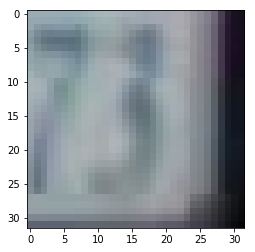

I think it says: 2


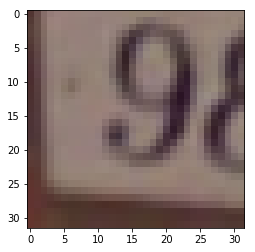

I think it says: 2


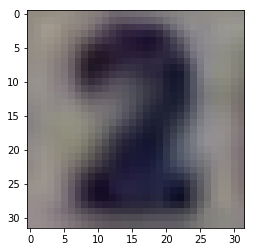

I think it says: 9


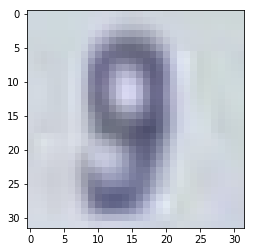

In [11]:
for j in range(4):
    r = random.randint(0, len(X_test2))
    pred = cropped_digit_model.predict(np.array([X_test2[r]]))
    print('I think it says: {0}'.format(np.argmax(pred)))
    plt.imshow(X_test2[r])
    plt.show()

### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:** The training and testing images are .png files, so I first used opencv to read them. They are already 32x32 so resizing was not required. I then normalized the images by dividing the pixel value by 255. The labels were one-hot encoded into binary arrays. The initial model achieves 87% validation accuracy and 84% test accuracy, which is lower than the metrics of the concatenated MNIST dataset, but is still reasonable.

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:** I had to make the convolutional neural network larger and deeper. I added two convolutional layers and increased the number of filters on these layers. I also increased the number of hidden units in the dense layers. One option that turned out to be worse was using 'sgd' as the optimizer rather than 'rmsprop', in which case the model gets stuck on a local minima very quickly (20% accuracy) and fails.

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:** The final model has good performance on realistic data, achieving 92% accuracy on both training and testing sets.

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [47]:
cap = cv2.VideoCapture(0)

while(True):
    ret, frame = cap.read()
    img = cv2.resize(frame,(32, 32), interpolation = cv2.INTER_LINEAR)
    cv2.imshow('frame',frame)
    img = np.reshape(img, (1, 32, 32, 3))
    pred = np.argmax(cropped_digit_model.predict(img))
    if pred == 10:
        pred = 0
    print('I think this is a {0}\r'.format(pred), end='')

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [16]:
cap.release()
cv2.destroyAllWindows()

### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

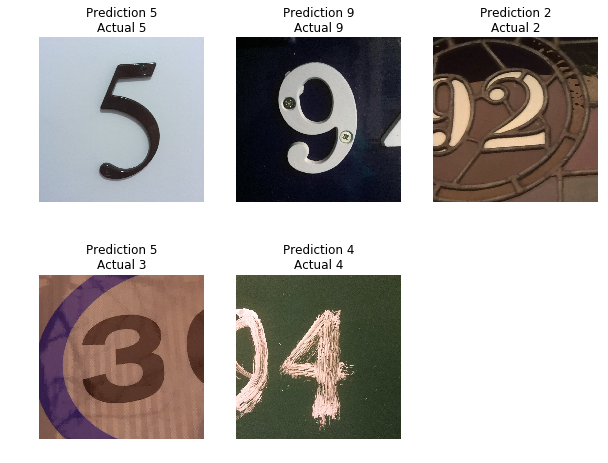

In [46]:
answers = [5,9,2,3,4]
plt.figure(figsize=(10, 8))
for i in range(5):
    img = cv2.imread(path.join('RealImages','{0}.jpg'.format(i)))
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    img = cv2.resize(img,(32, 32), interpolation = cv2.INTER_LINEAR)
    img = np.reshape(img, (1, 32, 32, 3))
    pred = np.argmax(cropped_digit_model.predict(img))
    plt.title("Prediction {}\nActual {}".format(pred, answers[i]))
    plt.axis('off')

**Answer:** The model got 4 out of the 5 numbers correct.The image it got wrong is an image of a road sign. However, it was taken at an angle that give it verticle stripes in the background. This is likely to have caused confusion in the classfier.

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:** The model performs equally well on captured pictures, though the result is not as good for live camera. The output of the model on a live video stream fluctuates a lot with the small movements of the camera, and it works less well then the digits are not at the centre of the image. 

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** I used opencv to capture video frame by frame. Each frame is resized to 32x32 pixels and is fed to the convolutional neural network. Then the output is passed to an argmax function and the result is the predicted label.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [2]:
IMG_HEIGHT = 32
IMG_WIDTH = 64
NUM_TRAIN = 10000
NUM_TEST = 2000
PATH = 'F:\Datasets\SVHN'

In [307]:
# The following class is a modified version of the one written by himanshudongre 
# Original code: https://github.com/himanshudongre/SVHN_Capstone_Project/blob/master/svhn_preprocess.ipynb

class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructBbox = self.inf['digitStruct']['bbox']

# bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox. 
    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

# getBbox returns a dict of data for the n(th) bbox. 
    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox
    
def make_save_dataset(nb_train, nb_test, nb_digits):
    
    def create(directory, data_points):
        digitFile = DigitStructFile(path.join(directory, 'digitStruct.mat'))
        X = np.empty((data_points, IMG_HEIGHT, IMG_WIDTH, 3))
        top = np.empty((nb_digits, data_points))
        left = np.empty((nb_digits, data_points))
        height = np.empty((nb_digits, data_points))
        width = np.empty((nb_digits, data_points))
        num_digits = np.empty((data_points, nb_digits))
        for i in range(data_points):
            img = cv2.imread(path.join(directory,'{0}.png').format(i+1), 1)            
            h, w, _ = img.shape
            box = digitFile.getBbox(i)
            box['top'] = np.array(box['top']) / h
            box['height'] = np.array(box['height']) / h
            box['left'] = np.array(box['left']) / w
            box['width'] = np.array(box['width']) / w
            d = len(box['top'])
            for j in range(nb_digits - d):
                for key, value in box.items():
                    box[key] = np.append(box[key], [0])
            top[:,i] = box['top']
            left[:,i] = box['left']
            height[:,i] = box['height']
            width[:,i] = box['width']
            num_digits[i] = (np.arange(nb_digits) == d-1).astype(int)
            img = cv2.resize(img,(IMG_WIDTH, IMG_HEIGHT))
            img = img / 255
            X[i] = img
            if i%1000 == 0:
                print('.', end='')
        return X, top, left, height, width, num_digits
    
    print("creating training set")
    x1, t1, l1, h1, w1, n1 = create(path.join(PATH, 'train'), nb_train)
    print("\ncreating test set")
    x2, t2, l2, h2, w2, n2 = create(path.join(PATH, 'test'), nb_test)
    
    obj = {
        'x1': x1,
        't1': t1,
        'l1': l1,
        'h1': h1,
        'w1': w1,
        'n1': n1,
        'x2': x2,
        't2': t2,
        'l2': l2,
        'h2': h2,
        'w2': w2,
        'n2': n2,
    }
    
    save_pickle("SVHN.pickle", obj)
    print("data saved to SVHN.pickle")

In [308]:
#make_save_dataset(10, 1, 4)
make_save_dataset(NUM_TRAIN, NUM_TEST, 5)

creating training set
..........
creating test set
..data saved to SVHN.pickle


In [3]:
data = load_pickle("SVHN.pickle")
for key in data.keys():
    print(key, data[key].shape)

n1 (10000, 5)
t1 (5, 10000)
w1 (5, 10000)
l2 (5, 2000)
x2 (2000, 32, 64, 3)
n2 (2000, 5)
w2 (5, 2000)
l1 (5, 10000)
t2 (5, 2000)
h1 (5, 10000)
x1 (10000, 32, 64, 3)
h2 (5, 2000)


In [4]:
def draw_boxes(img, n, t, l, h, w):
    for i in range(n):
        H, W, _ = img.shape
        img = cv2.rectangle(img,
                            (int(l[i] * W), int(t[i] * H)),
                            (int((l[i] + w[i]) * W),
                             int((t[i] + h[i]) * H))
                            ,(0,2,0),1)  
    return img

    
def show_boxes(data, n):
    for i in range(n):
        index = random.randint(0, len(data['x2'])-1)
        img = np.array(data['x2'][index])
        
        img = draw_boxes(img, np.argmax(data['n2'][index]) + 1, data['t2'][:,index],
                              data['l2'][:,index], data['h2'][:,index], data['w2'][:,index])
        plt.imshow(img)
        plt.show()

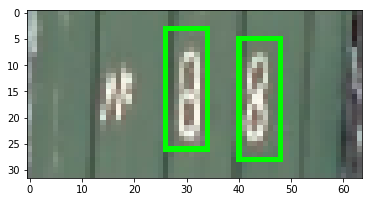

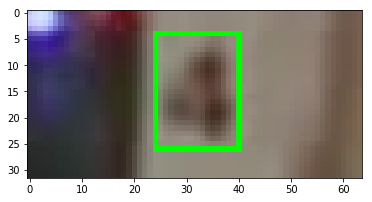

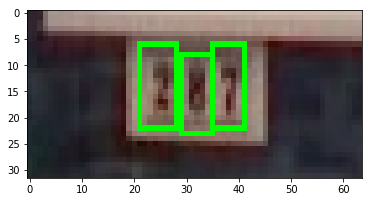

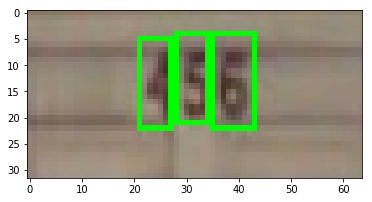

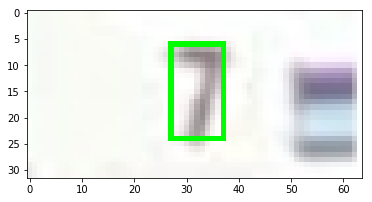

In [5]:
show_boxes(data, 5)

In [65]:
def create_reg_model(h, w, c):
    
    x = Input((h, w, c))

    m = Convolution2D(32, 3, 3, activation='relu')(x)
    m = Convolution2D(32, 3, 3, activation='relu')(m)
    m = MaxPooling2D(pool_size=(2, 2))(m)
    m = Dropout(0.35)(m)
                      
    m = Convolution2D(64, 3, 3, activation='relu')(m)
    m = Convolution2D(64, 3, 3, activation='relu')(m)
    m = MaxPooling2D(pool_size=(2, 2))(m)
    m = Dropout(0.35)(m)
    
    m = Convolution2D(128, 3, 3, activation='relu')(m)
    m = Convolution2D(128, 3, 3, activation='relu')(m)
    #m = MaxPooling2D(pool_size=(2, 2))(m)
    m = Dropout(0.35)(m)

    m = Flatten()(m)
    m = Dense(256, activation='relu')(m)
    m = Dropout(0.5)(m)
    
    l = Dense(128, activation='relu')(m)
    l = Dropout(0.5)(l)
    
    t = Dense(128, activation='relu')(m)
    t = Dropout(0.5)(t)
    
    h = Dense(128, activation='relu')(m)
    h = Dropout(0.5)(h)
    
    w = Dense(128, activation='relu')(m)
    w = Dropout(0.5)(w)
    
    num_digits = Dense(5, activation='softmax')(m)
    
    left0 = Dense(1, activation='sigmoid')(l)
    top0 = Dense(1, activation='sigmoid')(t)
    height0 = Dense(1, activation='sigmoid')(h)
    width0 = Dense(1, activation='sigmoid')(w)
    
    left1 = Dense(1, activation='sigmoid')(l)
    top1 = Dense(1, activation='sigmoid')(t)
    height1 = Dense(1, activation='sigmoid')(h)
    width1 = Dense(1, activation='sigmoid')(w)
    
    left2 = Dense(1, activation='sigmoid')(l)
    top2 = Dense(1, activation='sigmoid')(t)
    height2 = Dense(1, activation='sigmoid')(h)
    width2 = Dense(1, activation='sigmoid')(w)
    
    left3 = Dense(1, activation='sigmoid')(l)
    top3 = Dense(1, activation='sigmoid')(t)
    height3 = Dense(1, activation='sigmoid')(h)
    width3 = Dense(1, activation='sigmoid')(w)
    
    left4 = Dense(1, activation='sigmoid')(l)
    top4 = Dense(1, activation='sigmoid')(t)
    height4 = Dense(1, activation='sigmoid')(h)
    width4 = Dense(1, activation='sigmoid')(w)
    
    model = Model(input=x, output=[num_digits, 
                                   left0, top0, height0, width0,
                                   left1, top1, height1, width1,
                                   left2, top2, height2, width2,
                                   left3, top3, height3, width3,
                                   left4, top4, height4, width4])
    
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mean_squared_error'])
    
    return model

In [66]:
reg_model = create_reg_model(IMG_HEIGHT, IMG_WIDTH, 3)

reg_model.fit(data['x1'], [data['n1'],
                   data['l1'][0], data['t1'][0], data['h1'][0], data['w1'][0],
                   data['l1'][1], data['t1'][1], data['h1'][1], data['w1'][1],
                   data['l1'][2], data['t1'][2], data['h1'][2], data['w1'][2],
                   data['l1'][3], data['t1'][3], data['h1'][3], data['w1'][3],
                   data['l1'][4], data['t1'][4], data['h1'][4], data['w1'][4]
                  ], verbose=2)

reg_model.save('SVHN_reg_model')

Epoch 1/10
28s - loss: 0.5899 - dense_141_loss: 0.1277 - dense_142_loss: 0.0148 - dense_143_loss: 0.0168 - dense_144_loss: 0.0319 - dense_145_loss: 0.0084 - dense_146_loss: 0.0418 - dense_147_loss: 0.0179 - dense_148_loss: 0.0839 - dense_149_loss: 0.0096 - dense_150_loss: 0.0687 - dense_151_loss: 0.0144 - dense_152_loss: 0.0874 - dense_153_loss: 0.0060 - dense_154_loss: 0.0193 - dense_155_loss: 0.0034 - dense_156_loss: 0.0211 - dense_157_loss: 0.0035 - dense_158_loss: 0.0034 - dense_159_loss: 0.0025 - dense_160_loss: 0.0044 - dense_161_loss: 0.0028 - dense_141_mean_squared_error: 0.1277 - dense_142_mean_squared_error: 0.0148 - dense_143_mean_squared_error: 0.0168 - dense_144_mean_squared_error: 0.0319 - dense_145_mean_squared_error: 0.0084 - dense_146_mean_squared_error: 0.0418 - dense_147_mean_squared_error: 0.0179 - dense_148_mean_squared_error: 0.0839 - dense_149_mean_squared_error: 0.0096 - dense_150_mean_squared_error: 0.0687 - dense_151_mean_squared_error: 0.0144 - dense_152_mean

In [67]:
reg_model = load_model('SVHN_reg_model')

metrics = reg_model.evaluate(data['x2'], [data['n2'],
                   data['l2'][0], data['t2'][0], data['h2'][0], data['w2'][0],
                   data['l2'][1], data['t2'][1], data['h2'][1], data['w2'][1],
                   data['l2'][2], data['t2'][2], data['h2'][2], data['w2'][2],
                   data['l2'][3], data['t2'][3], data['h2'][3], data['w2'][3],
                   data['l2'][4], data['t2'][4], data['h2'][4], data['w2'][4]
                  ], verbose=2)
print(metrics)
print('average mean squared error {}'.format(np.mean(metrics[:int(len(metrics)/2)+1])))

[0.34753980779647825, 0.094344214975833895, 0.0059158276095986366, 0.014068226251751184, 0.030141482800245284, 0.0022972291205078364, 0.029344729512929917, 0.019164350599050521, 0.044945424064993855, 0.0026658487971872092, 0.04445954179763794, 0.01345847950130701, 0.035874911695718763, 0.0014939039237797261, 0.0048035945474985053, 0.0012116016110521742, 0.0032431373605213594, 0.00010330122128652874, 1.9165293312906009e-06, 5.7356965945398737e-07, 1.5118786991015756e-06, 2.1391769094357373e-12, 0.094344215631484984, 0.0059158276095986366, 0.014068226251751184, 0.030141482800245284, 0.0022972291205078364, 0.029344729512929917, 0.019164350599050521, 0.044945424064993855, 0.0026658487971872092, 0.04445954179763794, 0.01345847950130701, 0.035874911695718763, 0.0014939039237797261, 0.0048035945474985053, 0.0012116016110521742, 0.0032431373605213594, 0.00010330122128652874, 1.9165293312906009e-06, 5.7356965945398737e-07, 1.5118786991015756e-06, 2.1391769094357373e-12]
average mean squared err

In [68]:
def bounding_boxes(img, reg_model):
    out = reg_model.predict(np.array([img]))
    nb_digits = np.argmax(out[0]) + 1
    useful = out[1:nb_digits*4+1]
    print(nb_digits)
    l = []
    t = []
    h = []
    w = []
    for j in range(nb_digits):
        l.append(useful[j*4])
        t.append(useful[1 + j*4])
        h.append(useful[2 + j*4])
        w.append(useful[3 + j*4])
    l = np.array(l).reshape(nb_digits)
    t = np.array(t).reshape(nb_digits)
    h = np.array(h).reshape(nb_digits)
    w = np.array(w).reshape(nb_digits)
    img = draw_boxes(img, nb_digits, t, l, h, w)
    print(t, l, h, w)
    return img

2
[ 0.30938518  0.28404969] [ 0.57595682  0.63931185] [ 0.40691105  0.37651649] [ 0.10657267  0.09010581]


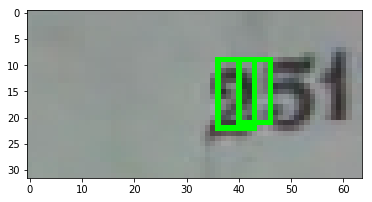

3
[ 0.2909694   0.27294245  0.24038906] [ 0.44582236  0.52356613  0.5353331 ] [ 0.45177603  0.46506345  0.41867703] [ 0.09060229  0.08183125  0.08025751]


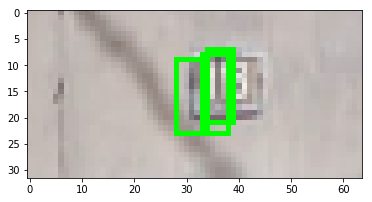

2
[ 0.24103294  0.22738305] [ 0.36200523  0.46980065] [ 0.59148705  0.5660044 ] [ 0.15113364  0.14604716]


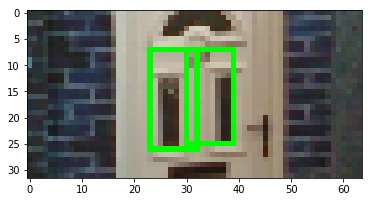

1
[ 0.09019145] [ 0.37346333] [ 0.73553395] [ 0.18821949]


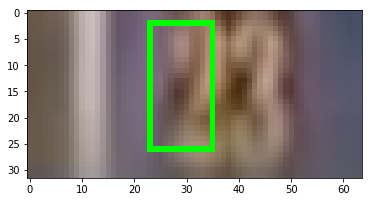

In [76]:
for i in range(4):
    img = data['x2'][random.randint(0,len( data['x2'])-1)]
    img = bounding_boxes(img, reg_model)
    plt.imshow(img)
    plt.show()

### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

2
[  1.04382216e-14   1.49543518e-13] [ 0.94219393  0.22454073] [ 0.99991047  0.84484124] [  8.02641176e-10   1.68071842e-13]
3
[ 1.          1.          0.00227401] [ 0.99999988  0.99977559  1.        ] [  0.00000000e+00   3.94178952e-39   0.00000000e+00] [  2.14811558e-38   4.00634235e-37   4.12220566e-32]
3
[ 1.          1.          0.13596763] [ 1.  1.  1.] [  0.00000000e+00   2.57369925e-35   3.11888412e-35] [  4.96179965e-30   3.27136000e-33   3.48454254e-30]
2
[ 0.15996519  0.18359366] [ 0.96993107  0.99104637] [  5.59512526e-14   1.67937844e-10] [  1.94567701e-06   5.21883658e-06]
3
[  5.16790390e-01   1.14546821e-01   5.08724770e-04] [ 0.76160097  0.97907001  1.        ] [  5.79239585e-15   2.93645090e-08   2.16882909e-04] [  5.00785307e-12   3.12918766e-12   2.54357950e-12]


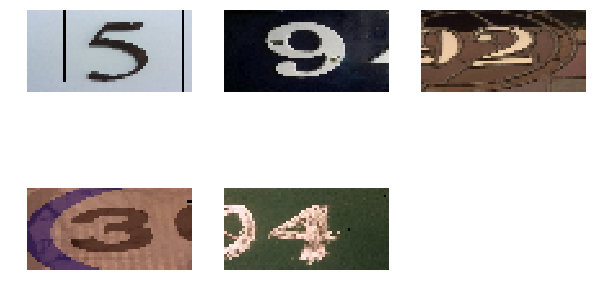

In [77]:
plt.figure(figsize=(10, 6))
for i in range(5):
    img = cv2.imread(path.join('RealImages','{0}.jpg'.format(i)))
    plt.subplot(2,3,i+1)
    img = cv2.resize(img,(IMG_WIDTH, IMG_HEIGHT), interpolation = cv2.INTER_LINEAR)
    img = bounding_boxes(img, reg_model)
    plt.imshow(img)
    plt.axis('off')

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.